In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import tarfile
import matplotlib
import matplotlib.pyplot as plt
import keras as keras

Using TensorFlow backend.


In [2]:
# datafile_path = '/Users/anjalikarimpil/Google Drive/Dissertation/Data/Social LSTM/'
datafile_path = '/users/mscdsa2018/ask2/Projects/Datasets/Social LSTM'
datafiles = os.listdir(datafile_path)
datafiles = [os.path.join(datafile_path, i) for i in datafiles if i.startswith('al_position') and i.endswith('tar.gz')]
print(datafiles)


['/users/mscdsa2018/ask2/Projects/Datasets/Social LSTM/al_position2013-02-10.csv.tar.gz', '/users/mscdsa2018/ask2/Projects/Datasets/Social LSTM/al_position2013-02-17.csv.tar.gz', '/users/mscdsa2018/ask2/Projects/Datasets/Social LSTM/al_position2013-02-16.csv.tar.gz', '/users/mscdsa2018/ask2/Projects/Datasets/Social LSTM/al_position2013-02-15.csv.tar.gz', '/users/mscdsa2018/ask2/Projects/Datasets/Social LSTM/al_position2013-02-12.csv.tar.gz', '/users/mscdsa2018/ask2/Projects/Datasets/Social LSTM/al_position2013-02-18.csv.tar.gz', '/users/mscdsa2018/ask2/Projects/Datasets/Social LSTM/al_position2013-02-09.csv.tar.gz', '/users/mscdsa2018/ask2/Projects/Datasets/Social LSTM/al_position2013-02-07.csv.tar.gz', '/users/mscdsa2018/ask2/Projects/Datasets/Social LSTM/al_position2013-02-06.csv.tar.gz', '/users/mscdsa2018/ask2/Projects/Datasets/Social LSTM/al_position2013-02-08.csv.tar.gz', '/users/mscdsa2018/ask2/Projects/Datasets/Social LSTM/al_position2013-02-19.csv.tar.gz', '/users/mscdsa2018/a

In [3]:
datafiles[0]

'/users/mscdsa2018/ask2/Projects/Datasets/Social LSTM/al_position2013-02-10.csv.tar.gz'

In [4]:
folders = []
tar = tarfile.open(datafiles[0], 'r:gz')
tar.extractall(datafiles[0].split('.', 1)[0])
tar.close()
folders.append(datafiles[0].split('.', 1)[0])

In [5]:
folders[0]
files = os.listdir(os.path.join(datafile_path, folders[0]))
files = [os.path.join(datafile_path, folders[0], i) for i in files]
# read first file in extracted folder
import pandas as pd
df=pd.read_csv(files[0], sep=';',header=None)


In [6]:
df['date'], df['time'] = df[0].str.split('T', 1).str
df[0] = pd.to_datetime(df[0], format="%Y-%m-%dT%H:%M:%S:%f")
df.columns = ['datetime', 'place', 'x_pos', 'y_pos', 'person_id', 'date', 'time']

In [7]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe()

,x_pos,y_pos,person_id
count,4338515.00,4338515.00,4338515.00
mean,44941.35,19315.18,2417.36
std,22191.10,10748.39,1630.09
min,1870.00,0.00,1.00
25%,25956.00,12813.00,794.00
50%,44589.00,14443.00,2356.00
75%,62170.00,20090.00,3889.00
max,93785.00,49940.00,5288.00


In [8]:
df.sort_values(['person_id','datetime'], inplace=True, ascending=True)

df['time_lead'] = df.groupby(['person_id', 'date'])['datetime'].shift(-1)
df['target_x'] = df.groupby(['person_id', 'date'])['x_pos'].shift(-1)
df['target_y'] = df.groupby(['person_id', 'date'])['y_pos'].shift(-1)

In [9]:

threshold = pd.to_timedelta('00:20:00.00000')
df['fl'] = np.where(abs(df['time_lead'] - df['datetime']) > threshold, 1, 0)
df.head(5)
df['traj_id'] = df['fl'].cumsum()
df.head(5)


,datetime,place,x_pos,y_pos,person_id,date,time,time_lead,target_x,target_y,fl,traj_id
0,2013-02-10 07:00:00.026,PIW,74446,5951,1,2013-02-10,07:00:00:026,2013-02-10 07:00:00.126,74441.00,6066.00,0,0
1,2013-02-10 07:00:00.126,PIW,74441,6066,1,2013-02-10,07:00:00:126,2013-02-10 07:00:00.226,74440.00,6105.00,0,0
2,2013-02-10 07:00:00.226,PIW,74440,6105,1,2013-02-10,07:00:00:226,2013-02-10 07:00:00.326,74440.00,6108.00,0,0
3,2013-02-10 07:00:00.326,PIW,74440,6108,1,2013-02-10,07:00:00:326,2013-02-10 07:00:00.426,74438.00,6145.00,0,0
4,2013-02-10 07:00:00.426,PIW,74438,6145,1,2013-02-10,07:00:00:426,2013-02-10 07:00:00.526,74437.00,6186.00,0,0


In [10]:
df.describe()

,x_pos,y_pos,person_id,target_x,target_y,fl,traj_id
count,4338515.00,4338515.00,4338515.00,4333227.00,4333227.00,4338515.00,4338515.00
mean,44941.35,19315.18,2417.36,44943.43,19310.68,0.00,726.24
std,22191.10,10748.39,1630.09,22180.72,10745.66,0.01,219.82
min,1870.00,0.00,1.00,1870.00,0.00,0.00,0.00
25%,25956.00,12813.00,794.00,25969.00,12813.00,0.00,794.00
50%,44589.00,14443.00,2356.00,44592.00,14440.00,0.00,835.00
75%,62170.00,20090.00,3889.00,62166.00,20048.50,0.00,835.00
max,93785.00,49940.00,5288.00,93785.00,49940.00,1.00,835.00


In [11]:
# index = 1
# df_1 = df.loc[df['traj_id'] == index]
# plt.scatter(df_1['x_pos'], df_1['y_pos'])
# plt.show()

In [12]:
np.ma.count(df['traj_id'].unique())

836

In [13]:
# from keras.preprocessing import sequence
# from keras.models import Sequential
# from keras.layers import Dense, Embedding
# from keras.layers import LSTM
# from keras.datasets import imdb
# import numpy as np

# max_features = 4 # 0,1,2,3 (total of 4)
# x = [
#     [[0],[1],[1],[0],[0],[0]],
#     [[0],[0],[0],[2],[2],[0]],
#     [[0],[0],[0],[0],[3],[3]],
#     [[0],[2],[2],[0],[0],[0]],
#     [[0],[0],[3],[3],[0],[0]],
#     [[0],[0],[0],[0],[1],[1]]
# ]
# x = np.array(x,dtype=np.float32)
# y = np.array([1,2,3,2,3,1],dtype=np.int32)

# # Convert y2 to dummy variables (one-hot encoding of y)
# y2 = np.zeros((y.shape[0], max_features),dtype=np.float32)
# y2[np.arange(y.shape[0]), y] = 1.0
# print(y2)

# print('Build model...')
# model = Sequential()
# model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, input_shape=(6, 1)))
# model.add(Dense(4, activation='sigmoid'))

# # try using different optimizers and different optimizer configs
# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
# print(x.shape, y.shape, y2.shape)
# # Work aayi?

In [14]:
# print('Train...')
# model.fit(x,y2,epochs=200)
# pred = model.predict(x)
# predict_classes = np.argmax(pred,axis=1)
# print("Predicted classes: {}",predict_classes)
# print("Expected classes: {}",predict_classes)

In [15]:

data = df[['traj_id','x_pos','y_pos']]
w = 20
for i in range(1, w + 1):
    data['x_'+str(i)] = data.groupby(['traj_id'])['x_pos'].shift(-i)
    data['y_'+str(i)] = data.groupby(['traj_id'])['x_pos'].shift(-i)
# Remove NAs 
data = data.dropna()

/users/mscdsa2018/ask2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/users/mscdsa2018/ask2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
data.head(5)

,traj_id,x_pos,y_pos,x_1,y_1,x_2,y_2,x_3,y_3,x_4,...,x_16,y_16,x_17,y_17,x_18,y_18,x_19,y_19,x_20,y_20
0,0,74446,5951,74441.00,74441.00,74440.00,74440.00,74440.00,74440.00,74438.00,...,74175.00,74175.00,74175.00,74175.00,74174.00,74174.00,74161.00,74161.00,74161.00,74161.00
1,0,74441,6066,74440.00,74440.00,74440.00,74440.00,74438.00,74438.00,74437.00,...,74175.00,74175.00,74174.00,74174.00,74161.00,74161.00,74161.00,74161.00,74162.00,74162.00
2,0,74440,6105,74440.00,74440.00,74438.00,74438.00,74437.00,74437.00,74449.00,...,74174.00,74174.00,74161.00,74161.00,74161.00,74161.00,74162.00,74162.00,74174.00,74174.00
3,0,74440,6108,74438.00,74438.00,74437.00,74437.00,74449.00,74449.00,74447.00,...,74161.00,74161.00,74161.00,74161.00,74162.00,74162.00,74174.00,74174.00,74184.00,74184.00
4,0,74438,6145,74437.00,74437.00,74449.00,74449.00,74447.00,74447.00,74431.00,...,74161.00,74161.00,74162.00,74162.00,74174.00,74174.00,74184.00,74184.00,74200.00,74200.00


In [26]:
from sklearn.model_selection import train_test_split
def dataset_generator(data):
    train = 0.8
    test = 0.2
#     dev = 0.1
    total_length = len(data)
    total_trajectories = np.ma.count(data['traj_id'].unique())
    train_ix = train * total_trajectories
    test_ix = test * total_trajectories
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 3:], data[['x_pos','y_pos']], 
                                                        train_size = 0.8, test_size = 0.2, random_state = 1)
    return X_train, X_test, y_train, y_test
#     dev_ix = dev * total_trajectories


In [34]:
X_train, X_test, y_train, y_test = dataset_generator(data)


In [35]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# X_train.reshape(shape = (-1, 10, 1 ))
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

(3457436, 40) (864359, 40) (3457436, 2) (864359, 2)


In [36]:
X_train = X_train.reshape((-1, 2, w) )
X_test = X_test.reshape((-1, 2, w) )

In [37]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3457436, 2, 20) (864359, 2, 20) (3457436, 2) (864359, 2)


In [38]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
import numpy as np


print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(2, w)))
model.add(Dense(2))

# try using different optimizers and different optimizer configs
model.compile(loss='mae',
              optimizer='adam',
              metrics=['accuracy'])



Build model...


In [39]:

print('Train...')
history = model.fit(X_train,y_train,epochs=25, batch_size = 64, validation_data=(X_test, y_test))

model.save('my_model.h5')

score = model.evaluate(X_test, y_test, batch_size=64)
print(score)

print('Predicting')
# predicted_output = model.predict(test_input, batch_size=72)

Train...
Train on 3457436 samples, validate on 864359 samples
Epoch 1/25
3457436/3457436 [==============================] - 154s 45us/step - loss: 30359.8810 - acc: 0.3246 - val_loss: 28295.2199 - val_acc: 0.1695
Epoch 2/25
3457436/3457436 [==============================] - 152s 44us/step - loss: 26212.7922 - acc: 0.1689 - val_loss: 24129.0684 - val_acc: 0.1695
Epoch 3/25
3457436/3457436 [==============================] - 148s 43us/step - loss: 22202.4086 - acc: 0.3914 - val_loss: 20400.9066 - val_acc: 0.8306
Epoch 4/25
3457436/3457436 [==============================] - 150s 43us/step - loss: 19256.0237 - acc: 0.8311 - val_loss: 18333.8004 - val_acc: 0.8305
Epoch 5/25
3457436/3457436 [==============================] - 147s 42us/step - loss: 17561.6796 - acc: 0.8311 - val_loss: 16807.8283 - val_acc: 0.8305
Epoch 6/25
3457436/3457436 [==============================] - 154s 44us/step - loss: 16143.5257 - acc: 0.8311 - val_loss: 15522.3028 - val_acc: 0.8305
Epoch 7/25
3457436/3457436 [====

In [40]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               76288     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 76,546
Trainable params: 76,546
Non-trainable params: 0
_________________________________________________________________
None


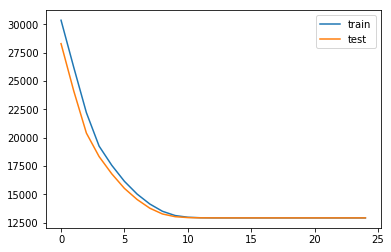

In [41]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [42]:
model.summary()
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               76288     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 76,546
Trainable params: 76,546
Non-trainable params: 0
_________________________________________________________________
Inputs: (None, 2, 20)
Outputs: (None, 2)


In [43]:
model = keras.models.load_model('my_model.h5')

In [44]:
y_hat_test = model.predict(X_test)

In [45]:
y_hat_test.shape

(864359, 2)

In [46]:

dist = np.linalg.norm(y_hat_test-y_test, axis=1)

In [47]:

print(1/len(dist)*(np.sum(dist)))


22336.2603866
